In [ ]:
#paper's authors' github:  https://github.com/Moradnejad/ColBERT-Using-BERT-Sentence-Embedding-for-Humor-Detection
#to run this, you will need to have downloaded the Colbert model as indicated on the authors' github page

In [1]:
import keras
import tensorflow as tf



model = keras.models.load_model("Colbert/colbert-trained/")
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 20)]         0                                            
_______________________________________________________________________________________

In [2]:
import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# import tensorflow_hub as hub
import tensorflow as tf
# import bert_tokenization as tokenization
import tensorflow.keras.backend as K
from tensorflow import keras 

import os
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

import seaborn as sns
import string
import re    #for regex

import contractions


np.set_printoptions(suppress=True)
print(tf.__version__)

2.4.1


In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("public_test.csv")
train_data.head()
test_data.head()

,id,text
0,9001,Finding out your ex got fat is like finding 20...
1,9002,"For Brockmann, stereotypes imperil national se..."
2,9003,A girl runs up to her mother with a pile of cr...
3,9004,gotta wonder if baseball still would've been c...
4,9005,When you're dreading getting in the shower cuz...


In [4]:
train_is_humor = train_data["is_humor"]
train_humor_rating = train_data["humor_rating"]
train_humor_controversy = train_data["humor_controversy"]
train_offense_rating = train_data["offense_rating"]
train_data = train_data.drop(columns = ['is_humor',"humor_rating", "humor_controversy", "offense_rating"])

train_data.head()


,id,text
0,1,TENNESSEE: We're the best state. Nobody even c...
1,2,A man inserted an advertisement in the classif...
2,3,How many men does it take to open a can of bee...
3,4,Told my mom I hit 1200 Twitter followers. She ...
4,5,Roses are dead. Love is fake. Weddings are bas...


In [4]:
print(train_data.iloc[1,1])

A man inserted an advertisement in the classifieds "Wife Wanted". The next day, he received 1000 of replies, all reading: "You can have mine." Free delivery also available at your door step


In [5]:
len(train_data.iloc[1,1])

189

In [7]:
word_list = train_data.iloc[1,1].split()
number_of_words = len(word_list)
print(number_of_words)

32


In [5]:
#preprocessing data to match what the paper did

indices = []
for i in range(len(train_data)):
    word_list = train_data.iloc[i,1].split()
    number_of_words = len(word_list)
    if (((len(train_data.iloc[i,1]) > 29) & (len(train_data.iloc[i,1]) < 101)) & ((number_of_words > 9) & (number_of_words < 19))):
        indices.append(i)
    train_data.iloc[i,1] = contractions.fix(train_data.iloc[i,1])
    train_data.iloc[i,1] = train_data.iloc[i, 1].capitalize().capitalize()

In [6]:
len(indices)

2893

In [10]:
train_data.iloc[3,1]

'Told my mom i hit 1200 twitter followers. she pointed out how my brother owns a house and i am wanted by several collection agencies. oh ma!'

In [9]:
train_data.shape

(8000, 2)

In [7]:
len(train_data.iloc[3,1])

139

In [7]:
train_data = train_data.iloc[indices, :]

In [10]:
len(train_data.iloc[3,1])

98

In [9]:
train_data.shape

(2893, 2)

In [8]:
train_is_humor = train_is_humor.iloc[indices]

In [10]:
train_is_humor.shape

(2893,)

In [11]:
#preprocessing test data as specified by paper

indices = []
for i in range(len(test_data)):
    word_list = test_data.iloc[i,1].split()
    number_of_words = len(word_list)
    if (((len(test_data.iloc[i,1]) > 29) & (len(test_data.iloc[i,1]) < 101)) & ((number_of_words > 9) & (number_of_words < 19))):
        indices.append(i)
    test_data.iloc[i,1] = contractions.fix(test_data.iloc[i,1])
    test_data.iloc[i,1] = test_data.iloc[i, 1].capitalize().capitalize()

In [12]:
test_data = test_data.iloc[indices, :]

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(train_data, train_is_humor, test_size=0.2, random_state=42)

In [32]:
train_is_humor.head()

0    1
1    1
2    1
3    1
4    1
Name: is_humor, dtype: int64

In [31]:
y_train.head()

1467    1
5768    0
5714    1
1578    0
6958    1
Name: is_humor, dtype: int64

In [27]:
X_train.shape

(6400, 2)

In [14]:
from transformers import BertTokenizer

MODEL_TYPE = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE)

In [15]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lwing\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
MAX_SENTENCE_LENGTH = 20
MAX_SENTENCES = 5
MAX_LENGTH = 100

In [17]:
def return_id(str1, str2, truncation_strategy, length):

    inputs = tokenizer.encode_plus(str1, str2,
        add_special_tokens=True,
        max_length=length,
        truncation_strategy=truncation_strategy)

    input_ids =  inputs["input_ids"]
    input_masks = [1] * len(input_ids)
    input_segments = inputs["token_type_ids"]
    padding_length = length - len(input_ids)
    padding_id = tokenizer.pad_token_id
    input_ids = input_ids + ([padding_id] * padding_length)
    input_masks = input_masks + ([0] * padding_length)
    input_segments = input_segments + ([0] * padding_length)

    return [input_ids, input_masks, input_segments]


def compute_input_arrays(df, columns, tokenizer):
    model_input = []
    for xx in range((MAX_SENTENCES*3)+3):
        model_input.append([])
    
    for _, row in tqdm(df[columns].iterrows()):
        i = 0
        
        # sent
        sentences = sent_tokenize(row.text)
        for xx in range(MAX_SENTENCES):
            s = sentences[xx] if xx<len(sentences) else ''
            ids_q, masks_q, segments_q = return_id(s, None, 'longest_first', MAX_SENTENCE_LENGTH)
            model_input[i].append(ids_q)
            i+=1
            model_input[i].append(masks_q)
            i+=1
            model_input[i].append(segments_q)
            i+=1
        
        # full row
        ids_q, masks_q, segments_q = return_id(row.text, None, 'longest_first', MAX_LENGTH)
        model_input[i].append(ids_q)
        i+=1
        model_input[i].append(masks_q)
        i+=1
        model_input[i].append(segments_q)
        
    for xx in range((MAX_SENTENCES*3)+3):
        model_input[xx] = np.asarray(model_input[xx], dtype=np.int32)
        
    print(model_input[0].shape)
    return model_input

In [18]:
inputs      = compute_input_arrays(X_train, ['text'], tokenizer)
test_inputs = compute_input_arrays(X_test, ['text'], tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



(2314, 20)



(579, 20)


In [19]:
xx = 7
print(X_train.iloc[xx,1])
print(sent_tokenize(X_train.iloc[xx,1]))

Q: what do you call a swimming pool full of blondes? a: frosted flakes.
['Q: what do you call a swimming pool full of blondes?', 'a: frosted flakes.']


In [36]:
print(type(y_train.to_frame()))

<class 'pandas.core.frame.DataFrame'>


In [20]:
def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

outputs = compute_output_arrays(y_train.to_frame(), ['is_humor'])

In [21]:
# Evaluation Metrics
import sklearn
def print_evaluation_metrics(y_true, y_pred, label='', is_regression=True, label2=''):
    print('==================', label2)
    ### For regression
    if is_regression:
        print('mean_absolute_error',label,':', sklearn.metrics.mean_absolute_error(y_true, y_pred))
        print('mean_squared_error',label,':', sklearn.metrics.mean_squared_error(y_true, y_pred))
        print('r2 score',label,':', sklearn.metrics.r2_score(y_true, y_pred))
        #     print('max_error',label,':', sklearn.metrics.max_error(y_true, y_pred))
        return sklearn.metrics.mean_squared_error(y_true, y_pred)
    else:
        ### FOR Classification
#         print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
#         print('average_precision_score',label,':', sklearn.metrics.average_precision_score(y_true, y_pred))
#         print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
#         print('accuracy_score',label,':', sklearn.metrics.accuracy_score(y_true, y_pred))
        print('f1_score',label,':', sklearn.metrics.f1_score(y_true, y_pred))
        
        matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
        print(matrix)
        TP,TN,FP,FN = matrix[1][1],matrix[0][0],matrix[0][1],matrix[1][0]
        Accuracy = (TP+TN)/(TP+FP+FN+TN)
        Precision = TP/(TP+FP)
        Recall = TP/(TP+FN)
        F1 = 2*(Recall * Precision) / (Recall + Precision)
        print('Acc', Accuracy, 'Prec', Precision, 'Rec', Recall, 'F1',F1)
        return sklearn.metrics.accuracy_score(y_true, y_pred)

In [22]:
valid_inputs = inputs
valid_outputs = outputs

In [23]:
model.trainable = False

In [24]:
# model.layers[25].trainable = True
# model.layers[26].trainable = True
# model.layers[27].trainable = True
# model.layers[28].trainable = True
# model.layers[29].trainable = True
# model.layers[30].trainable = True
# model.layers[31].trainable = True
# model.layers[32].trainable = True
# model.layers[33].trainable = True
# model.layers[34].trainable = True
# model.layers[35].trainable = True
# model.layers[36].trainable = True
# model.layers[37].trainable = True
# model.layers[38].trainable = True
# model.layers[39].trainable = True
# model.layers[40].trainable = True
# model.layers[41].trainable = True
# model.layers[42].trainable = True
# model.layers[43].trainable = True
# model.layers[44].trainable = True
model.layers[45].trainable = True
model.layers[46].trainable = True
model.layers[47].trainable = True

In [25]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
history = model.fit(x = valid_inputs, y = valid_outputs, epochs=10, validation_split = .1, shuffle=True)


Epoch 1/10
66/66 [==============================] - ETA: 28:27 - loss: 1.5582 - binary_accuracy: 0.78 - ETA: 6:13 - loss: 1.6563 - binary_accuracy: 0.7656 - ETA: 6:19 - loss: 1.7310 - binary_accuracy: 0.753 - ETA: 6:28 - loss: 1.7434 - binary_accuracy: 0.750 - ETA: 6:36 - loss: 1.7476 - binary_accuracy: 0.749 - ETA: 6:27 - loss: 1.7331 - binary_accuracy: 0.751 - ETA: 6:19 - loss: 1.7276 - binary_accuracy: 0.751 - ETA: 6:13 - loss: 1.7256 - binary_accuracy: 0.752 - ETA: 6:07 - loss: 1.7128 - binary_accuracy: 0.754 - ETA: 6:02 - loss: 1.7135 - binary_accuracy: 0.754 - ETA: 5:55 - loss: 1.7153 - binary_accuracy: 0.753 - ETA: 5:47 - loss: 1.7182 - binary_accuracy: 0.753 - ETA: 5:40 - loss: 1.7204 - binary_accuracy: 0.753 - ETA: 5:33 - loss: 1.7221 - binary_accuracy: 0.752 - ETA: 5:27 - loss: 1.7266 - binary_accuracy: 0.752 - ETA: 5:19 - loss: 1.7306 - binary_accuracy: 0.751 - ETA: 5:13 - loss: 1.7378 - binary_accuracy: 0.750 - ETA: 5:06 - loss: 1.7439 - binary_accuracy: 0.750 - ETA: 4:59 -

66/66 [==============================] - ETA: 7:02 - loss: 1.4257 - binary_accuracy: 0.843 - ETA: 6:35 - loss: 1.6176 - binary_accuracy: 0.796 - ETA: 6:33 - loss: 1.6943 - binary_accuracy: 0.774 - ETA: 6:28 - loss: 1.7540 - binary_accuracy: 0.760 - ETA: 6:20 - loss: 1.8109 - binary_accuracy: 0.749 - ETA: 6:15 - loss: 1.8928 - binary_accuracy: 0.736 - ETA: 6:08 - loss: 1.9619 - binary_accuracy: 0.727 - ETA: 6:02 - loss: 2.0060 - binary_accuracy: 0.721 - ETA: 5:57 - loss: 2.0289 - binary_accuracy: 0.717 - ETA: 5:50 - loss: 2.0401 - binary_accuracy: 0.715 - ETA: 5:45 - loss: 2.0426 - binary_accuracy: 0.714 - ETA: 5:38 - loss: 2.0380 - binary_accuracy: 0.714 - ETA: 5:32 - loss: 2.0373 - binary_accuracy: 0.713 - ETA: 5:26 - loss: 2.0350 - binary_accuracy: 0.713 - ETA: 5:19 - loss: 2.0377 - binary_accuracy: 0.712 - ETA: 5:15 - loss: 2.0421 - binary_accuracy: 0.711 - ETA: 5:09 - loss: 2.0454 - binary_accuracy: 0.710 - ETA: 5:04 - loss: 2.0460 - binary_accuracy: 0.710 - ETA: 4:58 - loss: 2.046

66/66 [==============================] - ETA: 6:45 - loss: 2.2825 - binary_accuracy: 0.718 - ETA: 6:54 - loss: 2.1761 - binary_accuracy: 0.726 - ETA: 6:39 - loss: 2.1666 - binary_accuracy: 0.720 - ETA: 6:36 - loss: 2.1236 - binary_accuracy: 0.722 - ETA: 6:26 - loss: 2.1281 - binary_accuracy: 0.717 - ETA: 6:17 - loss: 2.1312 - binary_accuracy: 0.715 - ETA: 6:13 - loss: 2.1377 - binary_accuracy: 0.713 - ETA: 6:05 - loss: 2.1359 - binary_accuracy: 0.711 - ETA: 5:59 - loss: 2.1338 - binary_accuracy: 0.710 - ETA: 5:52 - loss: 2.1320 - binary_accuracy: 0.710 - ETA: 5:45 - loss: 2.1290 - binary_accuracy: 0.709 - ETA: 5:40 - loss: 2.1219 - binary_accuracy: 0.709 - ETA: 5:34 - loss: 2.1187 - binary_accuracy: 0.709 - ETA: 5:27 - loss: 2.1106 - binary_accuracy: 0.710 - ETA: 5:21 - loss: 2.1024 - binary_accuracy: 0.711 - ETA: 5:14 - loss: 2.0952 - binary_accuracy: 0.711 - ETA: 5:09 - loss: 2.0847 - binary_accuracy: 0.712 - ETA: 5:02 - loss: 2.0764 - binary_accuracy: 0.713 - ETA: 4:56 - loss: 2.067

In [19]:
model.save("1layertransferlearn_10epoch_preprocessed")

INFO:tensorflow:Assets written to: 1layertransferlearn_10epoch_preprocessed\assets


INFO:tensorflow:Assets written to: 1layertransferlearn_10epoch_preprocessed\assets


In [23]:
model.save("4layertransferlearn_20epoch_model")

INFO:tensorflow:Assets written to: 4layertransferlearn_20epoch_model\assets


INFO:tensorflow:Assets written to: 4layertransferlearn_20epoch_model\assets


In [34]:
model.save("3layertransferlearn_10epoch_model_fullpreprocess")

INFO:tensorflow:Assets written to: 3layertransferlearn_10epoch_model_fullpreprocess\assets


INFO:tensorflow:Assets written to: 3layertransferlearn_10epoch_model_fullpreprocess\assets


In [26]:
model.save("3layertransferlearn_10epoch_model_fullpreprocess_v2")

INFO:tensorflow:Assets written to: 3layertransferlearn_10epoch_model_fullpreprocess_v2\assets


INFO:tensorflow:Assets written to: 3layertransferlearn_10epoch_model_fullpreprocess_v2\assets


In [14]:
model = keras.models.load_model("3layertransferlearn_10epoch_model_fullpreprocess")

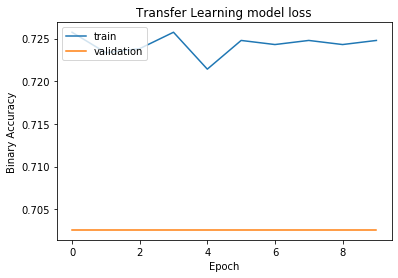

In [27]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Transfer Learning model loss')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
preds = model.predict(test_inputs)

In [21]:
print(preds)
print(X_test.head())
print(y_test)

[[0.99998647]
 [0.9999872 ]
 [0.99998295]
 ...
 [0.16755015]
 [0.99998045]
 [0.9999796 ]]
        id                                               text
2215  2216  If you are asian in the kitchen and african in...
2582  2583  Why is there only a stairway to heaven but a h...
1662  1663  I once dated a girl with a twin people asked m...
3027  3028  There are people out their happier with less t...
4343  4344  One zebra says to the other, "i am going to ch...
2215    1
2582    1
1662    1
3027    0
4343    1
       ..
1079    0
7979    1
1115    0
6093    1
6832    1
Name: is_humor, Length: 1600, dtype: int64


In [29]:
outputs = compute_output_arrays(y_test.to_frame(), ['is_humor'])

In [30]:
print(valid_outputs.shape, preds.shape)
print_evaluation_metrics(np.array(outputs), np.array(preds), '', True)

(2314, 1) (579, 1)
mean_absolute_error  : 0.2673404402310565
mean_squared_error  : 0.25609044898018485
r2 score  : -0.19905053361125913


0.25609044898018485

In [31]:
for split in np.arange(0.1, 0.99, 0.1).tolist():
    X_test['pred_bi'] = (preds > split)

    print_evaluation_metrics(y_test.to_frame()['is_humor'], X_test['pred_bi'], '', False, 'SPLIT on '+str(split))

C:\Users\lwing\Downloads\College\Spring 2020\M 340L\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


================== SPLIT on 0.1
f1_score  : 0.8289611752360966
[[ 21 158]
 [  5 395]]
Acc 0.7184801381692574 Prec 0.7142857142857143 Rec 0.9875 F1 0.8289611752360966


C:\Users\lwing\Downloads\College\Spring 2020\M 340L\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


================== SPLIT on 0.2
f1_score  : 0.8329809725158562
[[ 27 152]
 [  6 394]]
Acc 0.7271157167530224 Prec 0.7216117216117216 Rec 0.985 F1 0.8329809725158562


C:\Users\lwing\Downloads\College\Spring 2020\M 340L\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


================== SPLIT on 0.30000000000000004
f1_score  : 0.8356309650053022
[[ 30 149]
 [  6 394]]
Acc 0.7322970639032815 Prec 0.7255985267034991 Rec 0.985 F1 0.8356309650053022


C:\Users\lwing\Downloads\College\Spring 2020\M 340L\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


================== SPLIT on 0.4
f1_score  : 0.8343949044585988
[[ 30 149]
 [  7 393]]
Acc 0.7305699481865285 Prec 0.7250922509225092 Rec 0.9825 F1 0.8343949044585988


C:\Users\lwing\Downloads\College\Spring 2020\M 340L\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


================== SPLIT on 0.5
f1_score  : 0.8361702127659575
[[ 32 147]
 [  7 393]]
Acc 0.7340241796200345 Prec 0.7277777777777777 Rec 0.9825 F1 0.8361702127659575


C:\Users\lwing\Downloads\College\Spring 2020\M 340L\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


================== SPLIT on 0.6
f1_score  : 0.837953091684435
[[ 34 145]
 [  7 393]]
Acc 0.7374784110535406 Prec 0.7304832713754646 Rec 0.9825 F1 0.837953091684435


C:\Users\lwing\Downloads\College\Spring 2020\M 340L\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


================== SPLIT on 0.7000000000000001
f1_score  : 0.8385026737967914
[[ 36 143]
 [  8 392]]
Acc 0.7392055267702936 Prec 0.7327102803738318 Rec 0.98 F1 0.8385026737967914


C:\Users\lwing\Downloads\College\Spring 2020\M 340L\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


================== SPLIT on 0.8
f1_score  : 0.8344086021505376
[[ 37 142]
 [ 12 388]]
Acc 0.7340241796200345 Prec 0.7320754716981132 Rec 0.97 F1 0.8344086021505376


C:\Users\lwing\Downloads\College\Spring 2020\M 340L\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


================== SPLIT on 0.9
f1_score  : 0.8382193268186753
[[ 44 135]
 [ 14 386]]
Acc 0.7426597582037997 Prec 0.7408829174664108 Rec 0.965 F1 0.8382193268186753


In [ ]:
#Unrelated to paper; just trying out BERT tokenizer on william's model

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from gensim import utils
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.corpus import stopwords
from catboost import CatBoostClassifier

In [42]:
MODEL_TYPE = 'bert-base-uncased'
token = BertTokenizer.from_pretrained(MODEL_TYPE)

In [48]:
train_is_humor.to_frame().head()

,is_humor
0,1
1,1
2,1
3,1
4,1


In [50]:
for n in range(1, 6):
  # Pre-Processing
  cv = CountVectorizer(ngram_range=(n,n), tokenizer=token.tokenize)
  text_counts = cv.fit_transform(train_data['text'])
  X_train, X_test, y_train, y_test = train_test_split(text_counts, train_is_humor.to_frame()['is_humor'], test_size=0.25, random_state=42)
  
  # Modeling
  MNB = MultinomialNB()
  MNB.fit(X_train, y_train)
  predicted = MNB.predict(X_test)
  accuracy_score = metrics.accuracy_score(y_test, predicted)
  f1_score = metrics.f1_score(y_test, predicted)
  print(f'{n}-gram Accuracy: {accuracy_score:.4f}')
  print(f'{n}-gram F1-Score: {f1_score:.4f}')
  print()

1-gram Accuracy: 0.8580
1-gram F1-Score: 0.8885

2-gram Accuracy: 0.8605
2-gram F1-Score: 0.8884

3-gram Accuracy: 0.7795
3-gram F1-Score: 0.8002

4-gram Accuracy: 0.6085
4-gram F1-Score: 0.5609

5-gram Accuracy: 0.4980
5-gram F1-Score: 0.3438

